In [2]:
import os
import openai
from typing import List
from pydantic import BaseModel, Field
import pickle
import networkx as nx
import ast
import re
import json
import chromadb
import cProfile
import pstats

from datasets import load_dataset
from pprint import pprint

from langchain_groq import ChatGroq
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.utils.function_calling import convert_pydantic_to_openai_function
from langchain.agents import tool
from langchain_openai import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.callbacks import get_openai_callback
from langsmith import traceable

from commit import update
from utils.utils import serialize_dict_to_json, deserialize_json_to_dict
from utils.chunk import SimpleFixedLengthChunker
from utils.compress import get_skeleton

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key = os.environ['OPENAI_API_KEY']

sflc = SimpleFixedLengthChunker()

def neighbors_by_relation(G, node, relation_type):
    
    neighbors = []
    for u, v, data in G.edges(node, data=True):
        if data.get('relation') == relation_type:
            neighbor = v if u == node else u  # Handle undirected edges
            neighbors.append(neighbor)
    return neighbors

def load_graph(pickle_path):
    """Loads a NetworkX DiGraph from a pickle file."""
    with open(pickle_path, "rb") as f:
        graph = pickle.load(f)
    return graph

dataset = load_dataset("lahirum/SWE_Experimental", split="train")
# filter = [0, 1, 2, 3, 4,5, 6, 7, 8, 9]
# dataset = dataset.select(filter)


In [3]:
def extract_function_classes(file_path):
    try:
        with open(file_path, "r") as file:
            file_content = file.read()
            parsed_data = ast.parse(file_content)
    except Exception as e:  # Catch all types of exceptions
        print(f"Error in file {file_path}: {e}")
        return [], [], ""
    info = []

    for node in ast.walk(parsed_data):
        if isinstance(node, ast.ClassDef):
            info.append(node.name)
           
        elif isinstance(node, ast.FunctionDef) or isinstance(
            node, ast.AsyncFunctionDef
        ):
            if node.name =="__init__":
                continue
            info.append(node.name)             
    return info

import os

def get_file_structure(root_dir: str) -> dict:
    file_structure = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
      paths = dirpath.split("/")
      
      filenames = [file for file in filenames if file.endswith('.py')]
      rel_path = os.path.join(root_dir, dirpath)
      rel_path = "." if rel_path == "." else rel_path.replace("\\", "/")
      if "test" in dirpath:
          continue
      if not filenames:
        continue
    
    
      filenames = [dirpath+"/"+file for file in filenames]
      file_structure[dirpath] = filenames
    return file_structure


In [4]:
import prompts
import schema
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_deepseek import ChatDeepSeek

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    #max_retries=2,
)

llm_deepseek = ChatDeepSeek(
    model="deepseek-reasoner",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm_large = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_retries=2,
)


In [5]:
parser = JsonOutputFunctionsParser()

model_extract = llm_large.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousComponentOutput)],
    function_call="auto",
)

extract_chain = prompts.prompt_extract | model_extract

model_select = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.FileSuspicionOutput)],
    function_call="auto",
)
select_chain = prompts.file_path_filter_prompt | model_select

model_filter_list = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFilesOutputList)],
    function_call="auto",
)
filter_list_chain = prompts.get_suspicious_file_list_from_list_of_files_prompt | model_filter_list 

model_select_list = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFilesOutputList)],
    function_call="auto",
)
select_list_chain = prompts.suspicious_files_filter_list_usingclfn_prompt | model_select_list

model_select_with_reason = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFileReasoningOutput)],
    function_call="auto",
)

select_with_reason_chain = prompts.suspicious_files_with_reason_prompt | model_select_with_reason

model_select_directory = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousDirectoryOutput)],
    function_call="auto",
)
select_directory_chain = prompts.suspicious_directory_prompt | model_select_directory

generate_multiple_descriptions_chain = prompts.prompt_embedding_retriver | llm

model_deep_reason = llm.bind(
    functions=[convert_pydantic_to_openai_function(schema.SuspiciousFileDeepReasoningOutput)],
    function_call="auto",
)
deep_reasoning_chain = prompts.deep_reasoning_prompt | model_deep_reason

/tmp/ipykernel_814524/3754643000.py:4: LangChainDeprecationWarning: The function `_convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 1.0. Use :meth:`~langchain_core.utils.function_calling.convert_to_openai_function()` instead.
  functions=[convert_pydantic_to_openai_function(schema.SuspiciousComponentOutput)],


In [6]:
# with get_openai_callback() as callback:
#     result = extract_chain.invoke({"problem_description": problem_description})
#     # print(result)
#     print(callback)

In [7]:
# print(result)

In [8]:
import json
from commit import update

# @traceable(name=f"{instance_id}")
def start(inputs):
    problem_description = inputs['problem_description']
    name = inputs['name']
    graph = inputs['graph'] 
    commit_id = inputs['commit_id']
    instance_id = inputs["instance_id"]
    graph = inputs['graph'] 
    update(name, commit_id)
    with get_openai_callback() as callback:
        print("\n\n----- extract chain -----\n")
        result = extract_chain.invoke({"problem_description": problem_description})
        print(callback)
    result = result.additional_kwargs['function_call']['arguments']
    result = json.loads(result)
    result['name'] = name
    result['problem_description'] = problem_description
    result['graph'] = graph
    result['instance_id'] = instance_id
    return result

In [9]:
# print(start(problem_description, name,graph, commit_id))

In [10]:
from utils.compress import get_skeleton
import json

# @traceable(name=f"{instance_id}")
def get_most_suspicious_files(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    problem_description = inputs['problem_description']
    graph = inputs['graph']
    file = inputs['file']
    if "/" in file:
        file = file.split("/")[-1]
    if "." in file:
        file = file.split(".")[0]
    suspicious_files = []
    for neighbor in neighbors_by_relation(graph, "module_"+file,  'path'):
        if "test" in neighbor:
            continue
        suspicious_files.append(neighbor)
    with get_openai_callback() as callback:  
        print("\n\n----- select list of files chain 1 -----\n")
        filtered = select_chain.invoke({"problem_description": problem_description, "file_list": suspicious_files})
        print(callback)
    filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_file = filtered['suspicious_file']
    candiate_structure = {}
    for neighbor in neighbors_by_relation(graph, selected_file,  'imports')+[selected_file]:
        try:
            # with open(neighbor, "r", encoding="utf-8") as f:
            #     raw_code = f.read()
            candiate_structure[neighbor] = extract_function_classes(neighbor)
            # get_skeleton(raw_code, keep_constant = False, keep_indent=False, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    
    with get_openai_callback() as callback:      
        print("\n\n----- select list of files chain 2 -----\n")
        filtered_list = select_list_chain.invoke({"problem_description": problem_description, "file_structure": candiate_structure})
        print(callback)
    filtered_list = json.loads(filtered_list.additional_kwargs['function_call']['arguments'])
    filtered_list = filtered_list['suspicious_files']
    
    filtered_candidate_structure = {}
    for file in filtered_list:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:  
        print("\n\n----- select_with_reason_chain 1 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [11]:
# @traceable(name=f"{instance_id}")
def pass_problem_description(inputs):
    problem_description = inputs['problem_description']
    return problem_description

def pass_instance_id(inputs):
    instance_id = inputs['instance_id']
    return instance_id

In [12]:
# neighbors_by_relation(graph, "module_serializer",  'path')

In [13]:
# @traceable(name=f"{instance_id}")
def get_most_suspicious_files_using_clfn(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    
    problem_description = inputs['problem_description']
    graph = inputs['graph']
    class_function_name = inputs['class_function_name']
    print(class_function_name)

    if "." in class_function_name:
        class_function_name = class_function_name.split(".")[0]
    suspicious_files = []
    for neighbor in neighbors_by_relation(graph, "class_"+class_function_name,  'class_path'):
        if "test" in neighbor:
            continue
        suspicious_files.append(neighbor)
    print("class", suspicious_files)
    # filtered = select_list_class_chain.invoke({"problem_description": problem_description, "file_list": suspicious_files})
    # filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_file = suspicious_files #filtered['suspicious_files']
    # print(selected_file)
    
    filtered_candidate_structure = {}
    for file in selected_file:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:  
        print("\n\n----- select_with_reason_chain 2 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [14]:
# @traceable(name=f"{instance_id}")
def get_most_suspicious_files_using_file_structure(inputs):
    """
    Given a graph and a file, find the most suspicious files related to the given file.
    """
    name = inputs['name']
    problem_description = inputs['problem_description']
    
    file_structure = get_file_structure(name)
    
    directories = file_structure.keys()
    with get_openai_callback() as callback:  
        print("\n\n----- select single directory chain -----\n")
        filtered = select_directory_chain.invoke({"problem_description": problem_description, "directory_list": directories})
        print(callback)
    filtered = json.loads(filtered.additional_kwargs['function_call']['arguments'])
    selected_directory = filtered['suspicious_directory']
    if selected_directory in file_structure:
        suspicious_files = file_structure[selected_directory]
    elif name + "/" + selected_directory in file_structure:
        suspicious_files = file_structure[name + "/" + selected_directory]
    else:
        return
    
    print(len(suspicious_files))
    candiate_structure = {}
    for file in suspicious_files:
        try:
            candiate_structure[file] = extract_function_classes(file)
            # get_skeleton(raw_code, keep_constant = False, keep_indent=False, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    with get_openai_callback() as callback:   
        print("\n\n----- select list of files chain 3 -----\n") 
        filtered_list = select_list_chain.invoke({"problem_description": problem_description, "file_structure": candiate_structure})
        print(callback)
    filtered_list = json.loads(filtered_list.additional_kwargs['function_call']['arguments'])
    filtered_list = filtered_list['suspicious_files']
    
    
    filtered_candidate_structure = {}
    for file in filtered_list:
        try:
            with open(file, "r", encoding="utf-8") as f:
                raw_code = f.read()
            filtered_candidate_structure[file]=get_skeleton(raw_code, keep_constant = False, keep_indent=True, total_lines =15, prefix_lines=5,suffix_lines=5)
        except Exception as e:
            continue
    
    with get_openai_callback() as callback:
        print("\n\n----- select_with_reason_chain 3 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": filtered_candidate_structure})
        print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
    print("file", answer['suspicious_files'])
        
    return answer['suspicious_files']

In [15]:
# @traceable(name=f"{instance_id}")
def embedding_retriever(inputs):
    problem_description = inputs['problem_description']
    name = inputs['name']

    with get_openai_callback() as callback:
        print("\n\n----- generate multiple descriptions chain -----\n")
        multiple_descriptions = generate_multiple_descriptions_chain.invoke({"problem_description": inputs["problem_description"]})
        print(callback)

    problem_description = \
        f"""## **Original GitHub issue description**:\n\n{inputs["problem_description"]}\n\n\n## **Generated descriptions**:\n\n{multiple_descriptions.content}"""
    
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    chroma_client = chromadb.PersistentClient(f"chroma_db")
    collection = chroma_client.get_collection(name=f"{name}_chroma_index")

    vector_store = Chroma(
        client=chroma_client,
        collection_name=f"{name}_chroma_index",
        embedding_function=embeddings,
    )

    results = vector_store.similarity_search(problem_description, k=10,)
    # results = vector_store.max_marginal_relevance_search(problem_description, k=10, lambda_mult=0.5)

    file = deserialize_json_to_dict("django_file_ids.json")
    structure = {}
    for result in results:
        file_ids = file[result.metadata["filename"]].split(":")
        chunk_docs_of_file = vector_store.get_by_ids(file_ids)
        structure[result.metadata['filename']] = get_skeleton(sflc.dechunk_docs(chunk_docs_of_file))
        
    with get_openai_callback() as callback:
        print("\n\n----- select_with_reason_chain 4 -----\n")
        answer = select_with_reason_chain.invoke({"problem_description": problem_description, "file_structure": structure})
        print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])

    return answer['suspicious_files']
    

In [ ]:
# global_dict = {}

In [ ]:
# @traceable(name=f"{instance_id}")
def final_reasoning(inputs):
    candidates = []
    if inputs['get_suspicious_files']:
        candidates.extend(inputs['get_suspicious_files'])
        # global_dict[inputs['instance_id']]['get_suspicious_files'] = inputs['get_suspicious_files']
    if inputs['get_suspicious_files_using_clfn']:
        candidates.extend(inputs['get_suspicious_files_using_clfn'])
        # global_dict[inputs['instance_id']]['get_suspicious_files_using_clfn'] = inputs['get_suspicious_files_using_clfn']
    if inputs['get_suspicious_files_using_file_structure']:
        candidates.extend(inputs['get_suspicious_files_using_file_structure'])
        # global_dict[inputs['instance_id']]['get_suspicious_files_using_file_structure'] = inputs['get_suspicious_files_using_file_structure']
    if inputs['embedding_retriever']:   
        candidates.extend(inputs['embedding_retriever'])
        # global_dict[inputs['instance_id']]['embedding_retriever'] = inputs['embedding_retriever']
    
    for c in candidates:
        print(c)
    problem_description = inputs['problem_description']
    with get_openai_callback() as callback:  
        print("\n\n----- select_with_deep_reason_chain -----\n")
        answer = deep_reasoning_chain.invoke({"problem_description": problem_description, "candidates": candidates})
        print(callback)
    answer = json.loads(answer.additional_kwargs['function_call']['arguments'])
        
    return answer['suspicious_files']

In [18]:
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableSequence

start_run = RunnableLambda(start)
pass_problem_description_run = RunnableLambda(pass_problem_description)
pass_instance_id_run = RunnableLambda(pass_instance_id)
get_suspicious_files_run = RunnableLambda(get_most_suspicious_files)
get_suspicious_files_using_clfn_run = RunnableLambda(get_most_suspicious_files_using_clfn)
get_suspicious_files_using_file_structure_run = RunnableLambda(get_most_suspicious_files_using_file_structure)
embedding_retriever_run = RunnableLambda(embedding_retriever)
final_reasoning_run = RunnableLambda(final_reasoning)

parallel_run = RunnableParallel(
    {
        "get_suspicious_files": get_suspicious_files_run,
        "get_suspicious_files_using_clfn": get_suspicious_files_using_clfn_run,
        "get_suspicious_files_using_file_structure": get_suspicious_files_using_file_structure_run,
        "embedding_retriever": embedding_retriever_run,
        'problem_description': pass_problem_description_run,
        'instance_id': pass_instance_id_run
    }
)

In [19]:
full_flow = start_run | parallel_run | final_reasoning_run

In [ ]:
for i in range(0, 0):
    commit_id = dataset[i]['base_commit']
    instance_id = dataset[i]['instance_id']
    name = dataset[0]['instance_id'].split("__")[0]
    problem_description = dataset[i]['problem_statement']
    graph = load_graph(f"graph_{name}.pkl")
    # global_dict[instance_id] = {}
    # global_dict[instance_id]["erroneous_file"] = dataset[i]["erroneous_file"].strip()

    args = {"instance_id": instance_id, "problem_description": problem_description, "name": name, "graph": graph, "commit_id": commit_id}
    result = full_flow.invoke(
        args, 
        config={"run_name": f"{instance_id}"}
        )
    # global_dict[instance_id]["final_deep_reasoning_output"] = result
# serialize_dict_to_json(global_dict, "retriever-out.json")

django
DiGraph with 30954 nodes and 41452 edges
Checked out to 0456d3e42795481a186db05719300691fe2a1029
DiGraph with 30949 nodes and 41419 edges


----- extract chain -----

Tokens Used: 374
	Prompt Tokens: 346
		Prompt Tokens Cached: 0
	Completion Tokens: 28
		Reasoning Tokens: 0
Successful Requests: 1
Total Cost (USD): $0.001145


----- select list of files chain 1 -----



----- generate multiple descriptions chain -----

_build_app_dict
class ['django/django/contrib/admin/sites.py']


----- select_with_reason_chain 2 -----



----- select single directory chain -----

Tokens Used: 425
	Prompt Tokens: 396
		Prompt Tokens Cached: 0
	Completion Tokens: 29
		Reasoning Tokens: 0
Successful Requests: 1
Total Cost (USD): $7.68e-05


----- select list of files chain 2 -----

Tokens Used: 2191
	Prompt Tokens: 2166
		Prompt Tokens Cached: 0
	Completion Tokens: 25
		Reasoning Tokens: 0
Successful Requests: 1
Total Cost (USD): $0.00033989999999999997
15


----- select list of files chain 3 ---

In [103]:
from langsmith import Client
import traceback
from tqdm.notebook import tqdm

client = Client()

project_name = "debug.ai"

# Dictionary to store results
trace_outputs = {}
tracking_dict = \
    {
        "start": 0,
        "get_most_suspicious_files": 0,
        "get_most_suspicious_files_using_clfn": 0,
        "get_most_suspicious_files_using_file_structure": 0,
        "embedding_retriever": 0,
        "final_reasoning": 0,
    }

# List top-level runs (execution_order=1 means root runs only)
runs = client.list_runs(project_name=project_name, execution_order=1)

for run in tqdm(runs, desc="Processing..."):
    try:
        # print("instance_id:", run.name)
        # print()
        # print("erroneous_file:", dataset.filter(lambda instance: instance["instance_id"] == run.name)["erroneous_file"])
        # print()
        # print(run.name)
        erroneous_file = dataset.filter(lambda instance: instance["instance_id"] == run.name)["erroneous_file"][0]
        trace_outputs[run.name] = {}
        full_run = client.read_run(run.id, load_child_runs=True)
        for child_run in full_run.child_runs:
            if child_run.name == "start":
                # print("-" + child_run.name)
                # print(child_run.outputs["file"])
                trace_outputs[run.name][child_run.name] = False
                if child_run.outputs["file"]:
                    if child_run.outputs["file"].split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                        child_run.outputs["file"].split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                        trace_outputs[run.name][child_run.name] = True
                        tracking_dict[child_run.name] += 1
                continue
            if child_run.name == "final_reasoning":
                # print("-" + child_run.name)
                # print([item["file"] for item in child_run.outputs["output"]])
                # print()
                trace_outputs[run.name][child_run.name] = False
                if child_run.outputs["output"]:
                    for file in set([item["file"] for item in child_run.outputs["output"]]):
                        if file.split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                            file.split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                            trace_outputs[run.name][child_run.name] = True
                            tracking_dict[child_run.name] += 1
                continue
            for child_child_run in child_run.child_runs:
                if child_child_run.name != "pass_problem_description" and child_child_run.name != "pass_instance_id":
                    # print("--" + child_child_run.name)
                    # print([item["file"] for item in child_child_run.outputs["output"]])
                    # print()
                    trace_outputs[run.name][child_child_run.name] = False
                    if child_child_run.outputs["output"]:
                        for file in set([item["file"] for item in child_child_run.outputs["output"]]):
                            if file.split("/")[-2:][0] == erroneous_file.split("/")[-2:][0] and \
                                file.split("/")[-2:][1] == erroneous_file.split("/")[-2:][1]:
                                trace_outputs[run.name][child_child_run.name] = True
                                tracking_dict[child_child_run.name] += 1
        
    except Exception as e:
        print(run.name)
        traceback.print_exc()


Processing...: 0it [00:00, ?it/s]

django__django-14411


Traceback (most recent call last):
  File "/tmp/ipykernel_814524/1720266738.py", line 39, in <module>
    if child_run.outputs["file"]:
       ~~~~~~~~~~~~~~~~~^^^^^^^^
TypeError: 'NoneType' object is not subscriptable


In [137]:
# pprint(trace_outputs)

In [105]:
pprint(tracking_dict)

{'embedding_retriever': 26,
 'final_reasoning': 34,
 'get_most_suspicious_files': 20,
 'get_most_suspicious_files_using_clfn': 20,
 'get_most_suspicious_files_using_file_structure': 20,
 'start': 14}


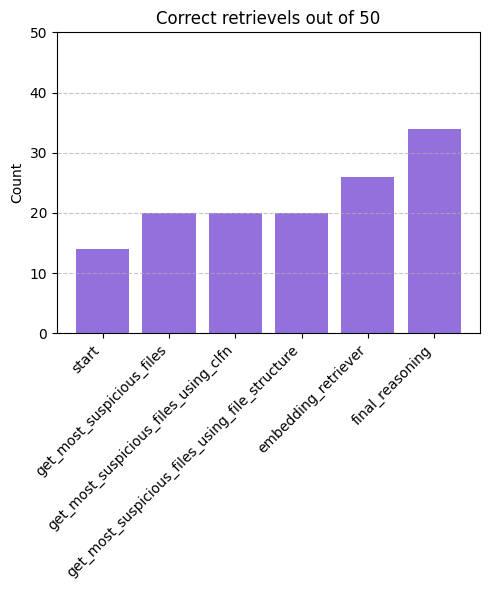

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 6))
plt.bar(tracking_dict.keys(), tracking_dict.values(), color='mediumpurple')

# Add labels and grid
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Correct retrievels out of 50")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 50)

# Show the plot
plt.tight_layout()
plt.show()

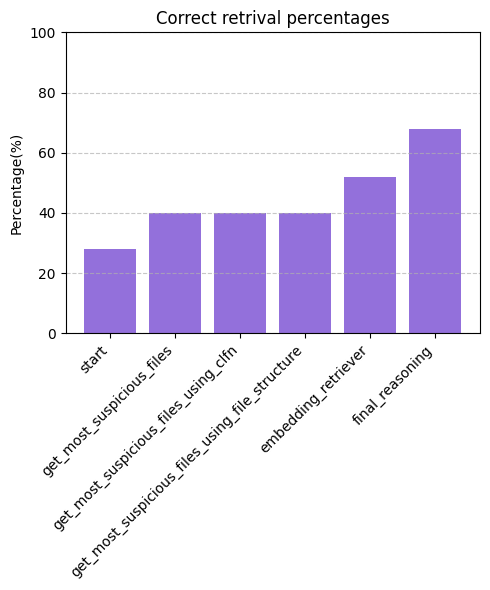

In [ ]:
import numpy as np

plt.figure(figsize=(5, 6))
plt.bar(tracking_dict.keys(), np.array(list(tracking_dict.values())) / 50 * 100, color='mediumpurple')

# Add labels and grid
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage(%)")
plt.title("Correct retrival percentages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()